In [1]:
%pip install PyniteFEA[all]
%pip install Pynite
%pip install trimesh

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
nodes_df = pd.read_csv(r'..\Documents/nodes.csv')
beams_df   = pd.read_csv(r'..\Documents\beams.csv')
columns_df = pd.read_csv(r'..\Documents\columns.csv')

FileNotFoundError: [Errno 2] No such file or directory: '..\\Documents/nodes.csv'

In [ ]:
# ─────────────────────────────────────────────────────────────────
# 1) IMPORTS
# ─────────────────────────────────────────────────────────────────
from Pynite.FEModel3D import FEModel3D
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────────────────────
# 2) READ YOUR CSV FILES
# ─────────────────────────────────────────────────────────────────
# (Adjust these paths if your files live somewhere else)

nodes_df = pd.read_csv(r'Documents/nodes.csv')
beams_df   = pd.read_csv(r'Documents\beams.csv')
columns_df = pd.read_csv(r'Documents\columns.csv')
# ─────────────────────────────────────────────────────────────────
# 3) INITIALIZE A NEW FINITE‐ELEMENT MODEL
# ─────────────────────────────────────────────────────────────────
model = FEModel3D()

# ─────────────────────────────────────────────────────────────────
# 4) ADD NODES TO THE MODEL
# ─────────────────────────────────────────────────────────────────
# For each row in nodes.csv, call add_node(ID, X, Y, Z)
# (PyNite will store them in model.nodes[ID].X, .Y, .Z)
for _, row in nodes_df.iterrows():
    node_id = str(row['ID'])
    x, y, z = row['X'], row['Y'], row['Z']
    model.add_node(node_id, x, y, z)

# ─────────────────────────────────────────────────────────────────
# 5) DEFINE MATERIAL & SECTION (JUST ONCE)
# ─────────────────────────────────────────────────────────────────
# You already know your steel E, G, fy, rho, etc.  Just define one “Steel” and one section:
E, G, fy, rho = 29000, 11200, 36, 2.836e-4
model.add_material('Steel', E, G, fy, rho)

# Pick a single section (e.g. W14X30) or define multiple if you have different shapes.
# Below is an example—adjust A, Iy, Iz, J to match your real section properties.
A, Iy, Iz, J = 8.84, 49.0, 14.4, 0.95
model.add_section('W14X30', A, Iy, Iz, J)

# ─────────────────────────────────────────────────────────────────
# 6) ADD MEMBERS (BEAMS + COLUMNS) TO THE MODEL
# ─────────────────────────────────────────────────────────────────
# (a) Add all beams from beams.csv
for _, row in beams_df.iterrows():
    beam_id = str(row['ID'])
    i_node  = str(row['i_node'])
    j_node  = str(row['j_node'])
    # Use the same material & section for all.  If you need different ones, branch here:
    model.add_member(beam_id, i_node, j_node, 'Steel', 'W14X30')

# (b) Add all columns from columns.csv
for _, row in columns_df.iterrows():
    col_id  = str(row['ID'])
    i_node  = str(row['i_node'])
    j_node  = str(row['j_node'])
    model.add_member(col_id, i_node, j_node, 'Steel', 'W14X30')

# ─────────────────────────────────────────────────────────────────
# 7) FIX YOUR SUPPORTS (ALL Z=0 NODES FULLY CLAMPED)
# ─────────────────────────────────────────────────────────────────
# Here we assume any node with Z == 0 is on the foundation.
# Fully fix all nodes at Z=0 in all 6 DOFs
for _, row in nodes_df.iterrows():
    if row['Z'] == 0:
        model.def_support(
            row['ID'],   # Node ID
            True, True, True,    # Tx, Ty, Tz fixed
            True, True, True     # Rx, Ry, Rz fixed
        )

    else:
        model.def_support(
            row['ID'],   # Node ID
            0, 0, 0,  # Tx, Ty, Tz free
            0, 0, 0   # Rx, Ry, Rz free
        )

# ─────────────────────────────────────────────────────────────────
# 8) COMPUTE MEMBER LENGTHS AUTOMATICALLY
# ─────────────────────────────────────────────────────────────────
# We’ll build two dictionaries so we know which IDs are “beams” and “columns” and their lengths:
beam_lengths = {}
for _, row in beams_df.iterrows():
    b_id    = str(row['ID'])
    ni, nj  = str(row['i_node']), str(row['j_node'])
    # Get coordinates of i_node, j_node
    xi, yi, zi = (model.nodes[ni].X, model.nodes[ni].Y, model.nodes[ni].Z)
    xj, yj, zj = (model.nodes[nj].X, model.nodes[nj].Y, model.nodes[nj].Z)
    # Euclidean distance = length
    length = float(np.sqrt((xj - xi)**2 + (yj - yi)**2 + (zj - zi)**2))
    beam_lengths[b_id] = length

column_lengths = {}
for _, row in columns_df.iterrows():
    c_id    = str(row['ID'])
    ni, nj  = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = (model.nodes[ni].X, model.nodes[ni].Y, model.nodes[ni].Z)
    xj, yj, zj = (model.nodes[nj].X, model.nodes[nj].Y, model.nodes[nj].Z)
    length = float(np.sqrt((xj - xi)**2 + (yj - yi)**2 + (zj - zi)**2))
    column_lengths[c_id] = length

# (Optional) Print them to verify:
print("Beam lengths:", beam_lengths)
print("Column lengths:", column_lengths)

# ─────────────────────────────────────────────────────────────────
# 9) APPLY UNIFORM DEAD LOAD (“sandbag line”) ON EACH MEMBER
# ─────────────────────────────────────────────────────────────────
#   Beams: use –0.02 kip/in over 0→L
#   Columns: use –0.01 kip/in over 0→L
for mem_id in model.members:
    if mem_id in beam_lengths:
        L = beam_lengths[mem_id]
        w_beam = -0.02
        model.add_member_dist_load(
            mem_id, 'FY',
            w_beam, w_beam,
            0, L,
            case='DL'
        )
    elif mem_id in column_lengths:
        L = column_lengths[mem_id]
        w_col = -0.01
        model.add_member_dist_load(
            mem_id, 'FY',
            w_col, w_col,
            0, L,
            case='DL'
        )
    else:
        # If somehow a member ID is neither in beam_lengths nor column_lengths, skip it.
        continue

# ─────────────────────────────────────────────────────────────────
# 10) (OPTIONAL) APPLY UNIFORM LIVE LOAD (“toy cars”) ON EACH MEMBER
# ─────────────────────────────────────────────────────────────────
# For example, beams get –0.015 kip/in, columns get –0.008 kip/in under Live Load case “LL”
for mem_id in model.members:
    if mem_id in beam_lengths:
        L = beam_lengths[mem_id]
        w_beam_LL = -0.015
        model.add_member_dist_load(
            mem_id, 'FY',
            w_beam_LL, w_beam_LL,
            0, L,
            case='LL'
        )
    elif mem_id in column_lengths:
        L = column_lengths[mem_id]
        w_col_LL = -0.008
        model.add_member_dist_load(
            mem_id, 'FY',
            w_col_LL, w_col_LL,
            0, L,
            case='LL'
        )
    else:
        continue

# ─────────────────────────────────────────────────────────────────
# 11) COMBINE DL + LL INTO ONE “ULS” BUCKET
# ─────────────────────────────────────────────────────────────────
model.add_load_combo('ULS', {'DL': 1.0, 'LL': 1.0})

# ─────────────────────────────────────────────────────────────────
# 12) RUN A LINEAR ANALYSIS (ASSEMBLE [K] ONCE)
# ─────────────────────────────────────────────────────────────────
# By using analyze_linear(), PyNite only builds the stiffness matrix once (because
# we have no tension‐only members or P-Delta effects in this example).
model.analyze_linear(combo_tags=['ULS'])
model.analyze
# ─────────────────────────────────────────────────────────────────
# 13) EXTRACT AND PRINT THE GLOBAL STIFFNESS MATRIX [K]
# ─────────────────────────────────────────────────────────────────
# Ask PyNite for the dense form of [K] under “ULS”:
K = model.K(combo_name='ULS', sparse=False)

# Build row/column labels: each node has 6 DOFs (DX,DY,DZ,RX,RY,RZ)
labels = []
for nid in model.nodes:
    labels += [f"{nid}_DX", f"{nid}_DY", f"{nid}_DZ",
               f"{nid}_RX", f"{nid}_RY", f"{nid}_RZ"]

# Turn it into a pandas DataFrame so you can inspect it
K_df = pd.DataFrame(K, index=labels, columns=labels)
print("Global Stiffness Matrix [K]:")
print(K_df)

# ─────────────────────────────────────────────────────────────────
# 14) (OPTIONAL) PRINT EVERY NODE’S DISPLACEMENT UNDER ULS
# ─────────────────────────────────────────────────────────────────
print("\nNODAL DISPLACEMENTS (under ULS):")
for nid, node in model.nodes.items():
    dx = node.DX.get('ULS', 0.0)
    dy = node.DY.get('ULS', 0.0)
    dz = node.DZ.get('ULS', 0.0)
    print(f"  Node {nid}:  DX = {dx:.6f} in,  DY = {dy:.6f} in,  DZ = {dz:.6f} in")


Beam lengths: {'B0': 2.8129093647003165, 'B1': 2.8129093647003183, 'B2': 2.8129093647003174, 'B3': 2.8129093647003165, 'B4': 2.8129093647003183, 'B5': 2.8129093647003174, 'B6': 2.8129093647003165, 'B7': 2.8129093647003183, 'B8': 2.8129093647003174, 'B9': 2.2553958892822266, 'B10': 2.2553958892822266, 'B11': 2.2553958892822266, 'B12': 2.2553958892822266, 'B13': 2.2553958892822266, 'B14': 2.2553958892822266, 'B15': 2.2553958892822266, 'B16': 2.2553958892822266, 'B17': 3.2604687213897705, 'B18': 3.2604687213897705, 'B19': 3.2604687213897705, 'B20': 3.420784950256348, 'B21': 3.420784950256347, 'B22': 3.420784950256348, 'B23': 3.420784950256347, 'B24': 2.5453494787216187, 'B25': 2.5453494787216187, 'B26': 2.5453494787216187, 'B27': 2.5453494787216187, 'B28': 1.810035228729248, 'B29': 1.810035228729248, 'B30': 1.810035228729248, 'B31': 3.01090931892395, 'B32': 3.01090931892395, 'B33': 3.0085062980651855, 'B34': 3.0085062980651855, 'B35': 2.560492515563965, 'B36': 2.560492515563965, 'B37': 2.

In [ ]:
# This cell prints K_df and also exports it as a CSV file.
print(K_df)

K_df.to_csv("global_stiffness_matrix.csv", index=True)


             N0_DX     N0_DY     N0_DZ     N0_RX      N0_RY  N0_RZ      N1_DX  \
N0_DX    1091328.0       0.0       0.0       0.0  1364160.0    0.0 -1091328.0   
N0_DY          0.0  320716.8       0.0 -400896.0        0.0    0.0        0.0   
N0_DZ          0.0       0.0  102544.0       0.0        0.0    0.0        0.0   
N0_RX          0.0 -400896.0       0.0  668160.0        0.0    0.0        0.0   
N0_RY    1364160.0       0.0       0.0       0.0  2273600.0    0.0 -1364160.0   
...            ...       ...       ...       ...        ...    ...        ...   
N107_DY        0.0       0.0       0.0       0.0        0.0    0.0        0.0   
N107_DZ        0.0       0.0       0.0       0.0        0.0    0.0        0.0   
N107_RX        0.0       0.0       0.0       0.0        0.0    0.0        0.0   
N107_RY        0.0       0.0       0.0       0.0        0.0    0.0        0.0   
N107_RZ        0.0       0.0       0.0       0.0        0.0    0.0        0.0   

            N1_DY     N1_DZ

Check symmetry programmatically: 

In [ ]:


np.allclose(K, K.T, atol=1e-6)


True

In [ ]:


# After running model.analyze(…) or model.analyze_linear(…):
for name, node in model.nodes.items():
    dx = node.DX   # displacement in global X
    dy = node.DY   # displacement in global Y
    dz = node.DZ   # displacement in global Z
    rx = node.RX   # rotation about global X
    ry = node.RY   # rotation about global Y
    rz = node.RZ   # rotation about global Z

    # Using the "ALL" load combo for output; change key if needed.
    print(f"Node {name}: DX = {dx.get('ULS', 0.0):.6f},  DY = {dy.get('ULS', 0.0):.6f},  DZ = {dz.get('ULS', 0.0):.6f}, "
          f"RX = {rx.get('ULS', 0.0):.6f},  RY = {ry.get('ULS', 0.0):.6f},  RZ = {rz.get('ULS', 0.0):.6f}")


Node N0: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N1: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N2: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N3: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N4: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N5: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N6: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N7: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N8: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N9: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000

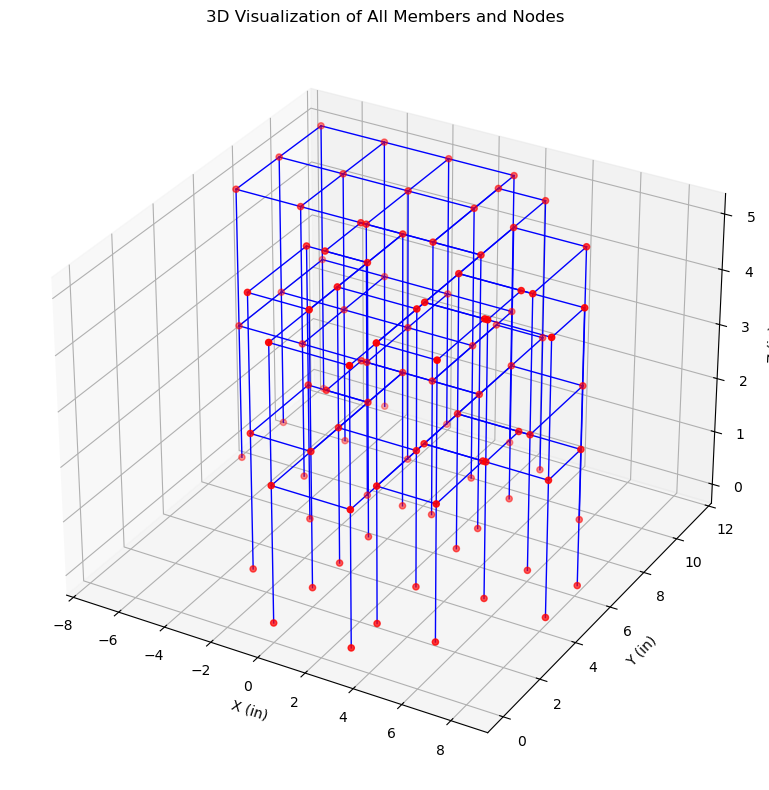

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot of all members and nodes in the PyNite model
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each member as a blue line between its two nodes
for member in model.members.values():
    # Use the node objects directly rather than looking them up by key
    node_i = member.i_node
    node_j = member.j_node
    xi, yi, zi = node_i.X, node_i.Y, node_i.Z
    xj, yj, zj = node_j.X, node_j.Y, node_j.Z
    # Plot line
    ax.plot([xi, xj], [yi, yj], [zi, zj], color='blue', linewidth=1)

# Plot all nodes as red dots
xs = [node.X for node in model.nodes.values()]
ys = [node.Y for node in model.nodes.values()]
zs = [node.Z for node in model.nodes.values()]
ax.scatter(xs, ys, zs, color='red', s=20)

# Label axes
ax.set_xlabel('X (in)')
ax.set_ylabel('Y (in)')
ax.set_zlabel('Z (in)')
ax.set_title('3D Visualization of All Members and Nodes')

plt.tight_layout()
plt.show()
